#### **A Manually Trained CNN for Bird Image Classification**

By Helen

Data source:

*   https://www.kaggle.com/datasets/gpiosenka/100-bird-species
* The dataset is reformated using codes from `load_split_data.ipynb`

Part of the codes in this notebook is based on the following Kaggle Notebooks:


*   https://www.kaggle.com/code/immortal36/bird-classification-cnn-not-pretrained-83-8
*   https://www.kaggle.com/code/akimball002/100-birds-cnn

Model description:

* Vanilla version - no adjustment of train/valid/test split; hyperparamter optimization by Bayesian Optimization in keras tuner

**Note:**
* This notebook is designed to run in Google Colab. Please make changes accordingly if you are running this notebook in other environments.




In [ ]:
! rm -r /kaggle/100-bird-species

rm: cannot remove '/kaggle/100-bird-species': No such file or directory


In [ ]:
#Used to make data more uniform across screen.
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [ ]:
!pip install keras-tuner --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.0 MB/s eta 0:00:00


In [ ]:
#Import packages used here:
# for initial data exploration:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
from IPython.display import Image, display
import random
import math

import os
import sys
from google.colab import userdata
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

#For modeling and model viewing.
import tensorflow as tf
from keras.preprocessing.image import load_img,img_to_array,ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import plot_model
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Activation, Concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import to_categorical #Image generator used for transformation to categorical
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras import backend, models
from tensorflow import keras
import keras_tuner as kt

#from sklearn.model_selection import train_test_split  #could have used on the consolidated file.
from sklearn.metrics import confusion_matrix

from tensorflow.keras.applications import VGG16, MobileNet
#from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import preprocess_input

#### Check if using gpu:

In [ ]:
print("Number of GPU(s) Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Number of GPU(s) Available:  1


#### Configuring Kaggle datasource and Download data

The Kaggle dataset used in this notebook is downloaded using `Secrets` in Colab. The variables `KAGGLE_KEY` and `KAGGLE_USERNAME` are obtained from personal Kaggle API.

Reference: https://www.kaggle.com/discussions/general/74235#:~:text=Using%20Secrets%20in%20Google%20Colab

In [ ]:
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

! kaggle datasets download -d gpiosenka/100-bird-species #option "Copy API Command"

! unzip "100-bird-species.zip" -d "/kaggle/100-bird-species"

Streaming output truncated to the last 5000 lines.
  inflating: /kaggle/100-bird-species/train/WHITE TAILED TROPIC/120.jpg  
  inflating: /kaggle/100-bird-species/train/WHITE TAILED TROPIC/121.jpg  
  inflating: /kaggle/100-bird-species/train/WHITE TAILED TROPIC/122.jpg  
  inflating: /kaggle/100-bird-species/train/WHITE TAILED TROPIC/123.jpg  
  inflating: /kaggle/100-bird-species/train/WHITE TAILED TROPIC/124.jpg  
  inflating: /kaggle/100-bird-species/train/WHITE TAILED TROPIC/125.jpg  
  inflating: /kaggle/100-bird-species/train/WHITE TAILED TROPIC/126.jpg  
  inflating: /kaggle/100-bird-species/train/WHITE TAILED TROPIC/127.jpg  
  inflating: /kaggle/100-bird-species/train/WHITE TAILED TROPIC/128.jpg  
  inflating: /kaggle/100-bird-species/train/WHITE TAILED TROPIC/129.jpg  
  inflating: /kaggle/100-bird-species/train/WHITE TAILED TROPIC/130.jpg  
  inflating: /kaggle/100-bird-species/train/WHITE TAILED TROPIC/131.jpg  
  inflating: /kaggle/100-bird-species/train/WHITE TAILED TROP

In [ ]:
print(f'Number of classes: {len(os.listdir("/kaggle/100-bird-species/train"))}')

Number of classes: 525


In [ ]:
#This will setup my directories for all of the data files in the 100-bird-species dataset.
BASE_DIR = '/kaggle/100-bird-species'
print('BASE_DIR contains ', os.listdir(BASE_DIR))
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VALIDATION_DIR = os.path.join(BASE_DIR, 'valid')
TEST_DIR = os.path.join(BASE_DIR, 'test')

BASE_DIR contains  ['valid', 'birds.csv', 'EfficientNetB0-525-(224 X 224)- 98.97.h5', 'test', 'train']


In [ ]:
#This will establish the prediction groups for the model.
CATEGORIES = os.listdir(TRAIN_DIR)
print(str(len(CATEGORIES)),'CATEGORIES are ', CATEGORIES)

Category_count = len(CATEGORIES)


525 CATEGORIES are  ['JANDAYA PARAKEET', 'WHITE EARED HUMMINGBIRD', 'MYNA', 'NORTHERN GANNET', 'FAIRY TERN', 'OCELLATED TURKEY', 'GOLDEN PIPIT', 'SNOWY EGRET', 'RED BEARDED BEE EATER', 'CHINESE POND HERON', 'LILAC ROLLER', 'NORTHERN MOCKINGBIRD', 'INDIAN VULTURE', 'AZARAS SPINETAIL', 'AZURE BREASTED PITTA', 'HIMALAYAN BLUETAIL', 'TURQUOISE MOTMOT', 'ROSEATE SPOONBILL', 'BANDED STILT', 'PALM NUT VULTURE', 'COMMON HOUSE MARTIN', 'CHATTERING LORY', 'ALBATROSS', 'GREAT GRAY OWL', 'JABIRU', 'AMERICAN DIPPER', 'STRIPPED MANAKIN', 'EURASIAN GOLDEN ORIOLE', 'GLOSSY IBIS', 'BEARDED REEDLING', 'RAZORBILL', 'INDIAN BUSTARD', 'ELEGANT TROGON', 'SNOWY SHEATHBILL', 'CALIFORNIA GULL', 'BLUE GROSBEAK', 'WHITE CRESTED HORNBILL', 'WHIMBREL', 'HOODED MERGANSER', 'BLONDE CRESTED WOODPECKER', 'RED BELLIED PITTA', 'GREAT JACAMAR', 'FRILL BACK PIGEON', 'VENEZUELIAN TROUPIAL', 'IMPERIAL SHAQ', 'LOGGERHEAD SHRIKE', 'FLAME TANAGER', 'PAINTED BUNTING', 'COLLARED ARACARI', 'RUBY THROATED HUMMINGBIRD', 'CAPUCHINBI

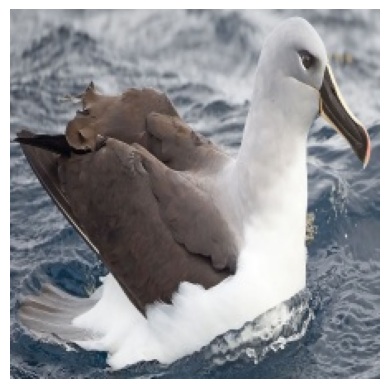

Figures are  (224, 224, 3)


In [ ]:
#Load an image and determine image shape for analysis.
IMAGE = load_img("/kaggle/100-bird-species/train/ALBATROSS/025.jpg")
plt.imshow(IMAGE)
plt.axis("off")
plt.show()

IMAGEDATA = img_to_array(IMAGE)
SHAPE = IMAGEDATA.shape
print('Figures are ', SHAPE)




#### Data cleaning - there's an extra space for one of the birds in the train and test dir:

In [ ]:
def check_directories(path):
    subdirs = os.listdir(path)
    print(f'Total directories in {path}: {len(subdirs)}')
    return set(os.listdir(path))

# Retrieve the list of species in each directory
train_species = check_directories(TRAIN_DIR)
test_species = check_directories(TEST_DIR)
valid_species = check_directories(VALIDATION_DIR)

# Find the union of all species (all species that appear in any directory)
all_species = train_species.union(test_species).union(valid_species)

# Find what is missing from each set
missing_from_train = all_species - train_species
missing_from_test = all_species - test_species
missing_from_valid = all_species - valid_species

print("Species missing from train:", missing_from_train)
print("Species missing from test:", missing_from_test)
print("Species missing from valid:", missing_from_valid)

Total directories in /kaggle/100-bird-species/train: 525
Total directories in /kaggle/100-bird-species/test: 525
Total directories in /kaggle/100-bird-species/valid: 525
Species missing from train: {'PARAKETT AUKLET'}
Species missing from test: {'PARAKETT AUKLET'}
Species missing from valid: {'PARAKETT  AUKLET'}


In [ ]:
# Define the incorrect and correct paths for train and test
incorrect_path_train = os.path.join(TRAIN_DIR, 'PARAKETT  AUKLET')
correct_path_train = os.path.join(TRAIN_DIR, 'PARAKETT AUKLET')

incorrect_path_test = os.path.join(TEST_DIR, 'PARAKETT  AUKLET')
correct_path_test = os.path.join(TEST_DIR, 'PARAKETT AUKLET')

# Rename the directories in train and test
try:
    os.rename(incorrect_path_train, correct_path_train)
    print(f"Renamed in train from '{incorrect_path_train}' to '{correct_path_train}'")
except FileNotFoundError as e:
    print(f"Error in train rename: {e}")

try:
    os.rename(incorrect_path_test, correct_path_test)
    print(f"Renamed in test from '{incorrect_path_test}' to '{correct_path_test}'")
except FileNotFoundError as e:
    print(f"Error in test rename: {e}")

Renamed in train from '/kaggle/100-bird-species/train/PARAKETT  AUKLET' to '/kaggle/100-bird-species/train/PARAKETT AUKLET'
Renamed in test from '/kaggle/100-bird-species/test/PARAKETT  AUKLET' to '/kaggle/100-bird-species/test/PARAKETT AUKLET'


In [ ]:
# Retrieve the list of species in each directory
train_species = check_directories(TRAIN_DIR)
test_species = check_directories(TEST_DIR)
valid_species = check_directories(VALIDATION_DIR)

# Find the union of all species (all species that appear in any directory)
all_species = train_species.union(test_species).union(valid_species)

# Find what is missing from each set
missing_from_train = all_species - train_species
missing_from_test = all_species - test_species
missing_from_valid = all_species - valid_species

print("Species missing from train:", missing_from_train)
print("Species missing from test:", missing_from_test)
print("Species missing from valid:", missing_from_valid)

Total directories in /kaggle/100-bird-species/train: 525
Total directories in /kaggle/100-bird-species/test: 525
Total directories in /kaggle/100-bird-species/valid: 525
Species missing from train: set()
Species missing from test: set()
Species missing from valid: set()


In [ ]:
# counts files
def count_images(directory):
    count = 0
    for _, _, files in os.walk(directory):
        count += len(files)
    return count

train_count = count_images(TRAIN_DIR)
valid_count = count_images(VALIDATION_DIR)
test_count = count_images(TEST_DIR)
train_split = train_count / (train_count+test_count+valid_count)
valid_split = valid_count / (train_count+test_count+valid_count)
test_split = test_count / (train_count+test_count+valid_count)


print(f"Number of images in Train: {train_count} with split: {train_split}")
print(f"Number of images in Valid: {valid_count} with split: {valid_split}")
print(f"Number of images in Test: {test_count} with split: {test_split}")

Number of images in Train: 84635 with split: 0.9415920342660066
Number of images in Valid: 2625 with split: 0.029203982866996717
Number of images in Test: 2625 with split: 0.029203982866996717


I'll create instances of ImageDataGenerators. One for all of the data being processed and more if I decide to augment my training data.

In [ ]:
#This will be used on training, test, and valid data
General_datagen = ImageDataGenerator(rescale=1./255, ) #Normalize pixel values to [0, 1] range using a floating-point scaling factor


The directories are not direct links to the data so I used the IMAGEDATAGENERATOR in Keras to consolidate the images for each train/test/validation set. I left the defaults as follows: batch_size = 32, class_mode = 'categorical', shuffle = TRUE(in flow).

In [ ]:
train_data = General_datagen.flow_from_directory(TRAIN_DIR, target_size=(224,224))
print('data groups:', len(train_data)) #Will be used to determine steps_per_epoch in my models.
Train_groups = len(train_data)
validation_data = General_datagen.flow_from_directory(VALIDATION_DIR, target_size=(224,224),)
image_qty = len(validation_data.filenames)
print('data groups:', len(validation_data))
print('validation image qty:',str(image_qty))
Valid_groups = len(validation_data)
test_data = General_datagen.flow_from_directory(TEST_DIR, target_size=(224,224),)
print('data groups:', len(test_data))

Found 84635 images belonging to 525 classes.
data groups: 2645
Found 2625 images belonging to 525 classes.
data groups: 83
validation image qty: 2625
Found 2625 images belonging to 525 classes.
data groups: 83


So to make certain my new datasets still had images and label seperation, I printed a few more images from the test set.

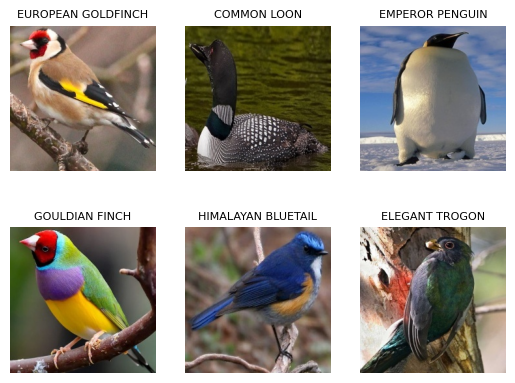

In [ ]:
#create seperate labels for images
def label_images2(DIR, dataset):
    label = []
    image = []
    j=0
    for i in range (0,30):
        j = random.randint(0, len(dataset.filenames)) #prints out random images each time
        label.append(dataset.filenames[j].split('/')[0])
        image.append(DIR + '/' + dataset.filenames[j])
    return [label,image]

#plot the random images.
y,x = label_images2(TRAIN_DIR, train_data)

for i in range(0,6):
    X = load_img(x[i])
    plt.subplot(2,3,+1 + i)
    plt.axis(False)
    plt.title(y[i], fontsize=8)
    plt.imshow(X)
plt.show()


#### Model

This set of optimal hyperparameters was obtained using the BayesianOptimization tuner in keras tuner.

In [ ]:
def get_model():
    model = Sequential()

    # Base Model
    model.add(Conv2D(filters=64, kernel_size=4, input_shape=(224, 224, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, padding='same'))

    model.add(Conv2D(filters=48, kernel_size=3, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, padding='same'))

    model.add(Conv2D(filters=128, kernel_size=4, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, padding='same'))

    model.add(Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, padding='same'))

    model.add(Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, padding='same'))

    #Top Model
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(384))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Dense(Category_count, activation='softmax'))

    model.summary()

    return model

model = get_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      3136      
                                                                 
 batch_normalization (Batch  (None, 224, 224, 64)      256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 48)      27696     
                                                                 
 batch_normalization_1 (Bat  (None, 112, 112, 48)      192       
 chNormalization)                                                
                                                        

#### Callbacks

In [ ]:
checkpoint_path = "/kaggle/checkpoint"

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=4,
    restore_best_weights=True,
    verbose=0
)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor="val_accuracy",
    save_best_only=True,
    verbose=0
)

# Training

In [ ]:
lr = 0.00035534
epochs = 20

In [ ]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(lr),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [ ]:
history = model.fit(
    train_data,
    epochs=epochs,
    validation_data=validation_data,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/20
2645/2645 [==============================] - 306s 111ms/step - loss: 3.8919 - accuracy: 0.2452 - val_loss: 2.0652 - val_accuracy: 0.5592
Epoch 2/20
2645/2645 [==============================] - 292s 110ms/step - loss: 2.0243 - accuracy: 0.5477 - val_loss: 1.2980 - val_accuracy: 0.6968
Epoch 3/20
2645/2645 [==============================] - 292s 110ms/step - loss: 1.4286 - accuracy: 0.6647 - val_loss: 0.9443 - val_accuracy: 0.7672
Epoch 4/20
2645/2645 [==============================] - 293s 111ms/step - loss: 1.0864 - accuracy: 0.7351 - val_loss: 0.7942 - val_accuracy: 0.8072
Epoch 5/20
2645/2645 [==============================] - 292s 110ms/step - loss: 0.8680 - accuracy: 0.7801 - val_loss: 0.7193 - val_accuracy: 0.8244
Epoch 6/20
2645/2645 [==============================] - 293s 111ms/step - loss: 0.7025 - accuracy: 0.8147 - val_loss: 0.7941 - val_accuracy: 0.8095
Epoch 7/20
2645/2645 [==============================] - 291s 110ms/step - loss: 0.5850 - accuracy: 0.8420 - val_

In [ ]:
model.save('/kaggle/CNN_not_pretrained_bayesian.keras')

#### Plot model accuracy curves

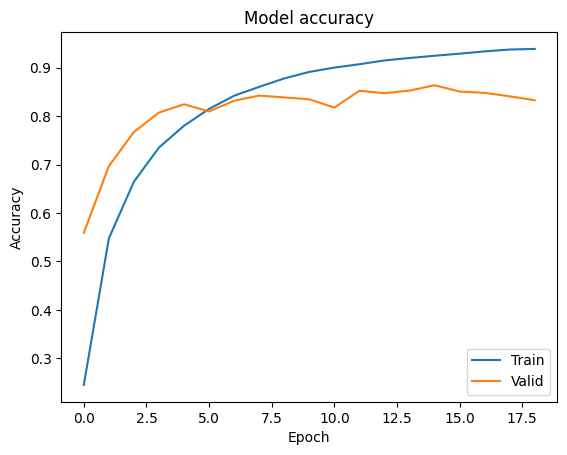

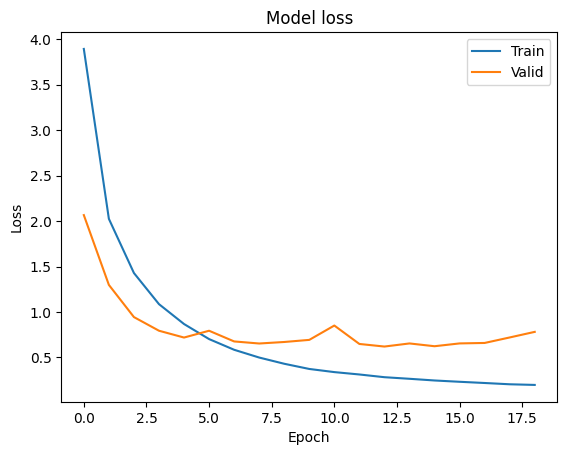

83/83 [==============================] - 5s 57ms/step - loss: 0.4982 - accuracy: 0.8773
Test loss: 0.49821507930755615
Test accuracy: 0.8773333430290222


In [ ]:
#plot accuracy vs epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='lower right')
plt.savefig('/kaggle/Model_accuracy_bayesian.png', dpi = 300, bbox_inches = 'tight', facecolor = 'white')
plt.show()

# Plot loss values vs epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper right')
plt.savefig('/kaggle/Model_loss_bayesian.png', dpi = 300, bbox_inches = 'tight', facecolor = 'white')
plt.show()

# Evaluate against test data.
scores = model.evaluate(test_data, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

#### Sanity check: reload saved model

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
reload_model = load_model('/kaggle/CNN_not_pretrained_bayesian.keras')

In [ ]:
# Evaluate against test data.
scores = reload_model.evaluate(test_data, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

83/83 [==============================] - 6s 70ms/step - loss: 0.4982 - accuracy: 0.8773
Test loss: 0.49821484088897705
Test accuracy: 0.8773333430290222
